In [1]:
import os
import pandas as pd
import numpy as np
from sklearn import preprocessing
import pickle
import matplotlib.pyplot as plt
import cv2
import plotly.graph_objs as go
import seaborn as sns
import matplotlib.cm as cm
import matplotlib
from mpl_toolkits.mplot3d import Axes3D
import mplcursors 
import random
import torch
from scipy.stats import pearsonr

In [ ]:
def partition_in_train_and_test(video_data_folder, init_window, end_window, train_traces, test_traces,user_test_traces=None,video_test_traces=None):
    partition = {}
    partition['train'] = []
    partition['test'] = []
    for trace in train_traces:
        user = str(trace[0])
        video = trace[1]
        # to get the length of the trace
        trace_length = get_video_length(video_data_folder, video, user).shape[0]
        for tstap in range(init_window, trace_length - end_window):
            ID = {'video': video, 'user': user, 'time-stamp': tstap}
            partition['train'].append(ID)
    for trace in test_traces:
        user = str(trace[0])
        video = trace[1]
        # to get the length of the trace
        trace_length = get_video_length(video_data_folder, video, user).shape[0]
        for tstap in range(init_window, trace_length - end_window):
            ID = {'video': video, 'user': user, 'time-stamp': tstap}
            partition['test'].append(ID)
            
    if user_test_traces is not None:
        partition['user_test']=[]
        for trace in user_test_traces:
            user = str(trace[0])
            video = trace[1]
            # to get the length of the trace
            trace_length = get_video_length(video_data_folder, video, user).shape[0]
            for tstap in range(init_window, trace_length - end_window):
                ID = {'video': video, 'user': user, 'time-stamp': tstap}
                partition['user_test'].append(ID)
    
    if video_test_traces is not None:
        partition['video_test']=[]
        for trace in video_test_traces:
            user = str(trace[0])
            video = trace[1]
            # to get the length of the trace
            trace_length = get_video_length(video_data_folder, video, user).shape[0]
            for tstap in range(init_window, trace_length - end_window):
                ID = {'video': video, 'user': user, 'time-stamp': tstap}
                partition['video_test'].append(ID)
            
    return partition

In [37]:
def plot_SITI(dataset_name,datasets_folder, annotate_all=False, color='blue'):
    dataset_folder=os.path.join(datasets_folder,dataset_name)
    video_img_folder=os.path.join(dataset_folder,'5fps_Video_Images')
    videos=os.listdir(video_img_folder)
    video_SIs=[]
    video_TIs=[]
    for video in videos:
        array_folder=os.path.join(video_img_folder,video)
        SI=np.load(os.path.join(array_folder,'video_SI.npy'))
        TI=np.load(os.path.join(array_folder,'video_TI.npy'))
        
        # Aggregating based on ITU-T P.910 (10/2023)
        video_SIs.append(np.mean(SI))
        video_TIs.append(np.mean(TI))
    # Plotting the results
    plt.figure(figsize=(10, 6))
    plt.scatter(video_SIs, video_TIs, color=color, marker='o')

    if annotate_all:
        for i, video in enumerate(videos):
            plt.annotate(video, (video_SIs[i], video_TIs[i]))

    plt.title(f'Spatial and Temporal Information for {dataset_name}')
    plt.xlabel('Spatial Information (SI)')
    plt.ylabel('Temporal Information (TI)')
    plt.grid(True)
    
    plots_folder = os.path.join('Plots', 'SITI')
    os.makedirs(plots_folder, exist_ok=True)
    plot_path = os.path.join(plots_folder, f'{dataset_name}_SITI_plot.png')
    plt.savefig(plot_path)
    plt.show()
    
    
    

In [39]:
def plot_all_SITI(datasets_folder, datasets, annotate_all=False):
    plt.figure(figsize=(10, 6))
    colors = cm.rainbow(np.linspace(0, 1, len(datasets)))

    for idx, dataset_name in enumerate(datasets):
        dataset_folder = os.path.join(datasets_folder, dataset_name)
        video_img_folder = os.path.join(dataset_folder, '5fps_Video_Images')
        videos = os.listdir(video_img_folder)
        video_SIs = []
        video_TIs = []

        for video in videos:
            array_folder = os.path.join(video_img_folder, video)
            SI = np.load(os.path.join(array_folder, 'video_SI.npy'))
            TI = np.load(os.path.join(array_folder, 'video_TI.npy'))
            
            # Aggregating based on ITU-T P.910 (10/2023)
            video_SIs.append(np.mean(SI))
            video_TIs.append(np.mean(TI))

        plt.scatter(video_SIs, video_TIs, color=colors[idx], label=dataset_name)

        if annotate_all:
            for i, video in enumerate(videos):
                plt.annotate(video, (video_SIs[i], video_TIs[i]), fontsize=8, color=colors[idx])

    plt.title('Spatial and Temporal Information for Multiple Datasets')
    plt.xlabel('Spatial Information (SI)')
    plt.ylabel('Temporal Information (TI)')
    plt.legend()
    plt.grid(True)
    plots_folder = os.path.join('Plots', 'SITI')
    os.makedirs(plots_folder, exist_ok=True)
    plot_path = os.path.join(plots_folder, f'all_datasets_SITI_plot.png')
    plt.savefig(plot_path)
    plt.show()

In [33]:
datasets_folder="D:/"
datasets=['Jin_22','MMSys18','PAMI18','CVPR18','Fan_NOSSDAV_17']
dataset_colors = cm.rainbow(np.linspace(0, 1, len(datasets)))

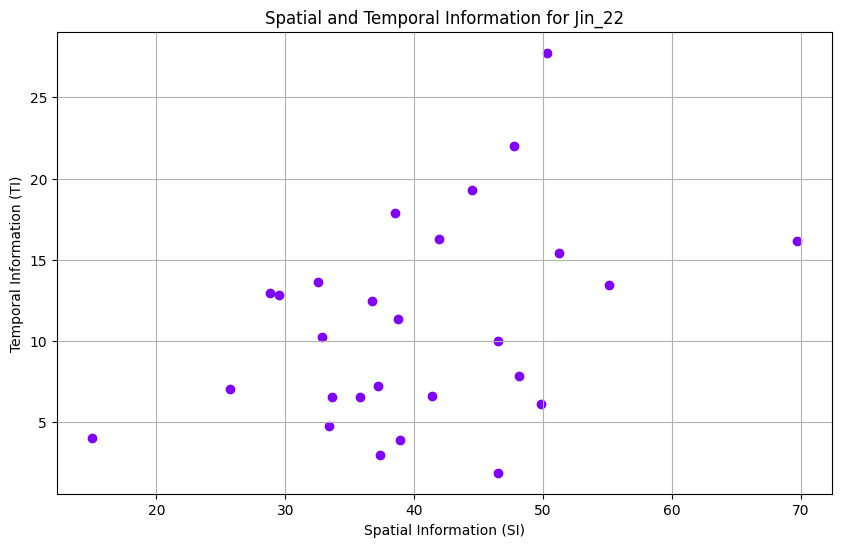

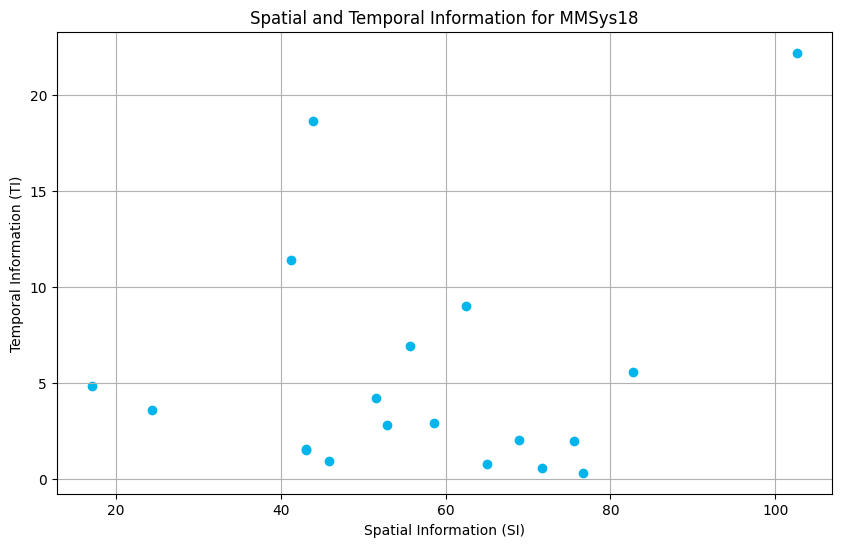

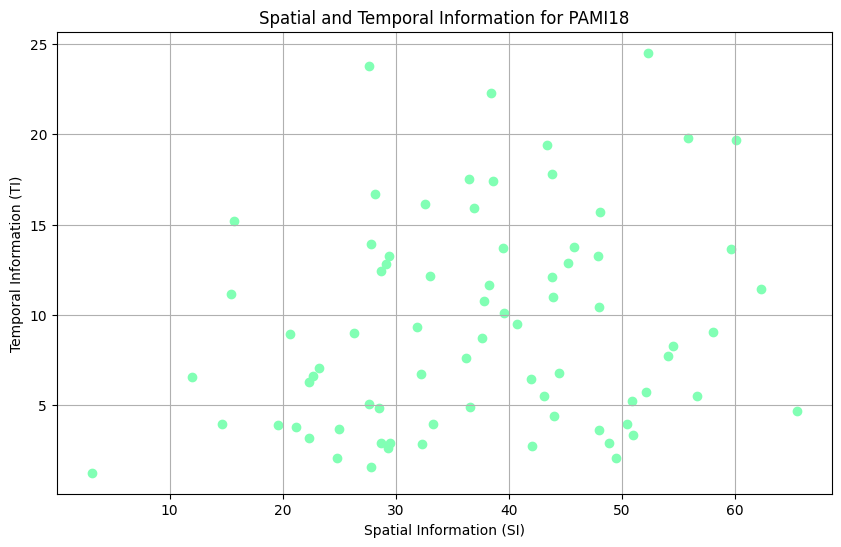

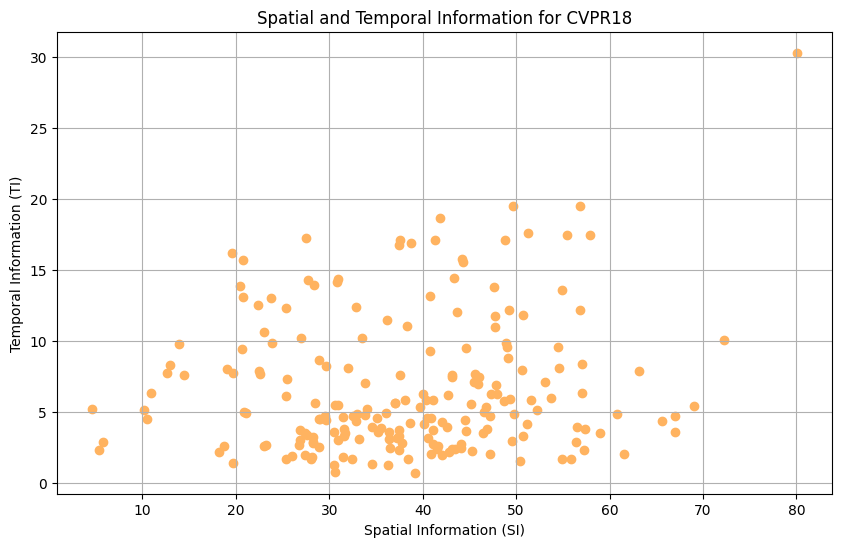

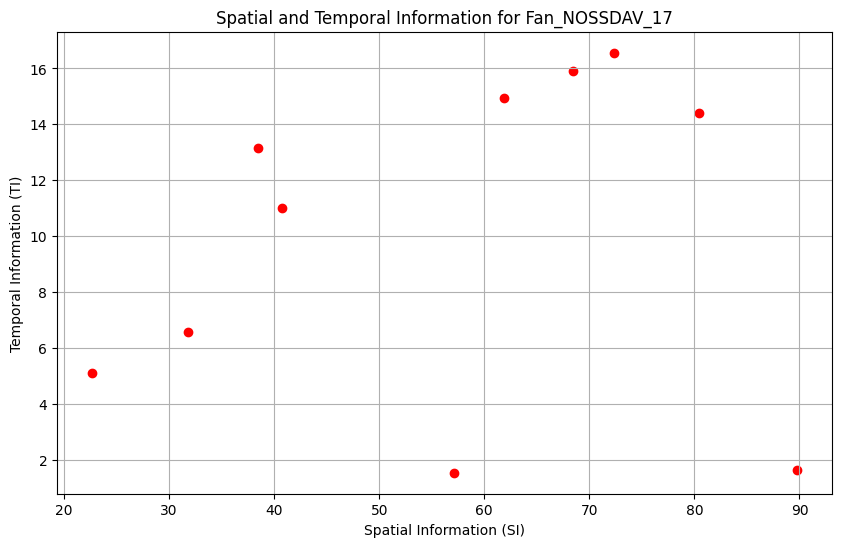

In [38]:
for idx,dataset in enumerate(datasets):
    plot_SITI(dataset,datasets_folder,color=dataset_colors[idx])

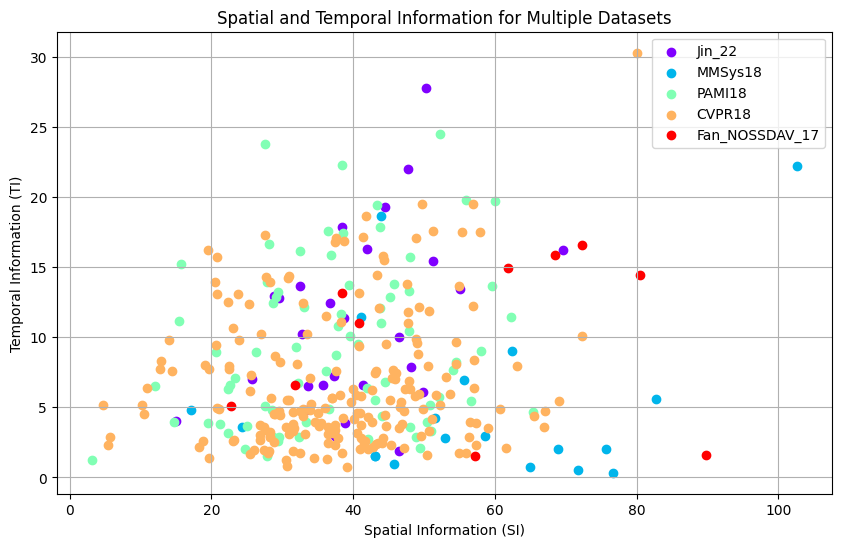

In [40]:
plot_all_SITI(datasets_folder,datasets)

In [8]:
def fetch_c_entropies(datasets_folder, dataset):
    dataset_folder = os.path.join(datasets_folder, dataset)
    video_img_folder = os.path.join(dataset_folder, '5fps_Video_Images')
    data_path = os.path.join(dataset_folder, 'video_data')
    videos = os.listdir(video_img_folder)
    entropies = {}
    
    for video in videos:
        entropy_path = os.path.join(data_path, video, f'{video}_content_entropy.npy')
        
        if os.path.exists(entropy_path):
            entropy = np.load(entropy_path)
            entropies[video] = entropy
            
    return entropies


def plot_mean_c_entropies(datasets_folder, datasets):
    all_mean_entropies = []
    color_map = plt.cm.get_cmap('tab10', len(datasets))  # Use a colormap with distinct colors

    # Collect mean entropies for all datasets
    for dataset_index, dataset in enumerate(datasets):
        entropies = fetch_c_entropies(datasets_folder, dataset)
        
        for video, entropy_values in entropies.items():
            mean_entropy = np.mean(entropy_values)
            all_mean_entropies.append((video, mean_entropy, dataset_index))  # Store dataset_index for color

    # Sort by mean entropy
    all_mean_entropies.sort(key=lambda x: x[1])  # Sort by mean entropy

    # Prepare for plotting
    sorted_videos, sorted_mean_values, dataset_indices = zip(*all_mean_entropies)

    plt.figure(figsize=(12, 8))
    legend_handles = {} 
    # Plotting
    for video, mean_entropy, dataset_index in all_mean_entropies:
        color = color_map(dataset_index)
        plt.bar(video, mean_entropy, color=color, alpha=0.6)
        
        # Add to legend if not already added
        if dataset not in legend_handles:
            legend_handles[dataset] = plt.bar([], [], color=color, label=dataset)  # Create empty bar for legend
    print(legend_handles)
    plt.title('Mean Content Entropy for Each Video Across Datasets')
    plt.xlabel('Videos')
    plt.ylabel('Mean Content Entropy')
    plt.xticks(rotation=45)
    plt.legend(handles=list(legend_handles.values()), title='Datasets', handletextpad=0.5, borderpad=0.5)
    plt.grid(axis='y')
    plt.tight_layout()  # Adjust layout for better spacing
    plt.show()


C:\Users\Varun\AppData\Local\Temp\ipykernel_14580\3817350145.py:20: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  color_map = plt.cm.get_cmap('tab10', len(datasets))  # Use a colormap with distinct colors


{'PAMI18': <BarContainer object of 0 artists>}


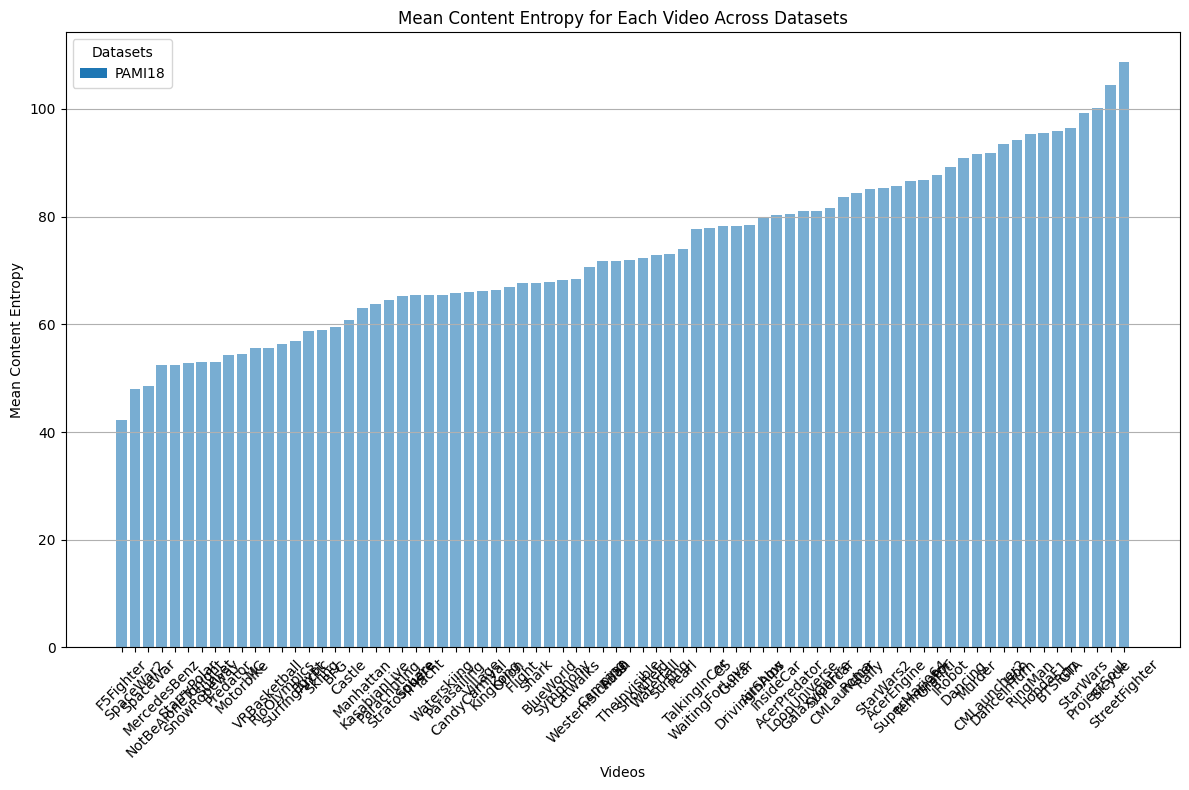

In [9]:
plot_mean_c_entropies(datasets_folder, datasets[2:3])

In [10]:
def plot_c_entropy(datasets_folder,dataset):
    data_path=os.path.join(datasets_folder,dataset,'video_data')
    vids=os.listdir(data_path)
    entropies={}
    for vid in vids:
        entropy_path=os.path.join(data_path,vid,f'{vid}_content_entropy.npy')
        vid_entropy=np.load(entropy_path)
        entropies[vid]=vid_entropy
    plt.figure(figsize=(12, 6))

    for vid, entropy in entropies.items():
        plt.plot(entropy, label=vid)

    plt.title(f'Content Entropy for Videos in {dataset}')
    plt.xlabel('Frame Index')
    plt.ylabel('Entropy')
    plt.legend()
    plt.grid(True)
    plt.show()

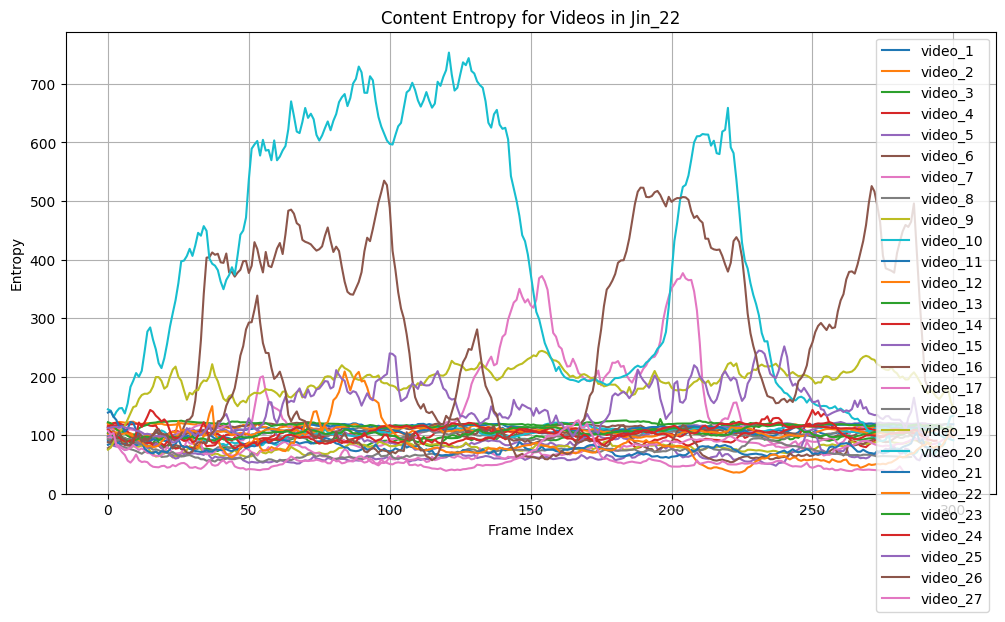

In [11]:
plot_c_entropy(datasets_folder,datasets[0])

In [106]:
def plot_mean_entropy_vs_SITI(datasets_folder, dataset):
    dataset_folder = os.path.join(datasets_folder, dataset)
    video_img_folder = os.path.join(dataset_folder, '5fps_Video_Images')
    data_path = os.path.join(dataset_folder, 'video_data')
    
    videos = os.listdir(video_img_folder)
    mean_SIs = []
    mean_TIs = []
    mean_entropies = []
    
    for video in videos:
        # Load SI and TI values
        array_folder = os.path.join(video_img_folder, video)
        SI_path = os.path.join(array_folder, 'video_SI.npy')
        TI_path = os.path.join(array_folder, 'video_TI.npy')
        
        if os.path.exists(SI_path) and os.path.exists(TI_path):
            SI = np.load(SI_path)
            TI = np.load(TI_path)
            mean_SIs.append(np.mean(SI))
            mean_TIs.append(np.mean(TI))
        
        # Load content entropy values
        entropy_path = os.path.join(data_path, video, f'{video}_content_entropy.npy')
        
        if os.path.exists(entropy_path):
            entropy = np.load(entropy_path)
            mean_entropies.append(np.mean(entropy))
    
    # Determine vmin and vmax for the colormap to handle outliers
    vmin = np.percentile(mean_entropies, 5)
    vmax = np.percentile(mean_entropies, 95)
    
    # Plot mean SI vs mean TI with content entropy as colormap
    plt.figure(figsize=(10, 8))
    scatter = plt.scatter(mean_SIs, mean_TIs, c=mean_entropies, cmap='coolwarm', marker='o', vmin=vmin, vmax=vmax)
    
    plt.title(f'Mean TI vs Mean SI with Content Entropy for {dataset}')
    plt.xlabel('Mean Spatial Information (SI)')
    plt.ylabel('Mean Temporal Information (TI)')
    colorbar = plt.colorbar(scatter, label='Mean Content Entropy')
    plt.grid(True)
    plt.tight_layout()
    plots_folder = os.path.join('Plots', 'SITI_entropy')
    os.makedirs(plots_folder, exist_ok=True)
    plot_path = os.path.join(plots_folder, f'{dataset}_SITI_with_entropy_plot.png')
    plt.savefig(plot_path)
    plt.show()

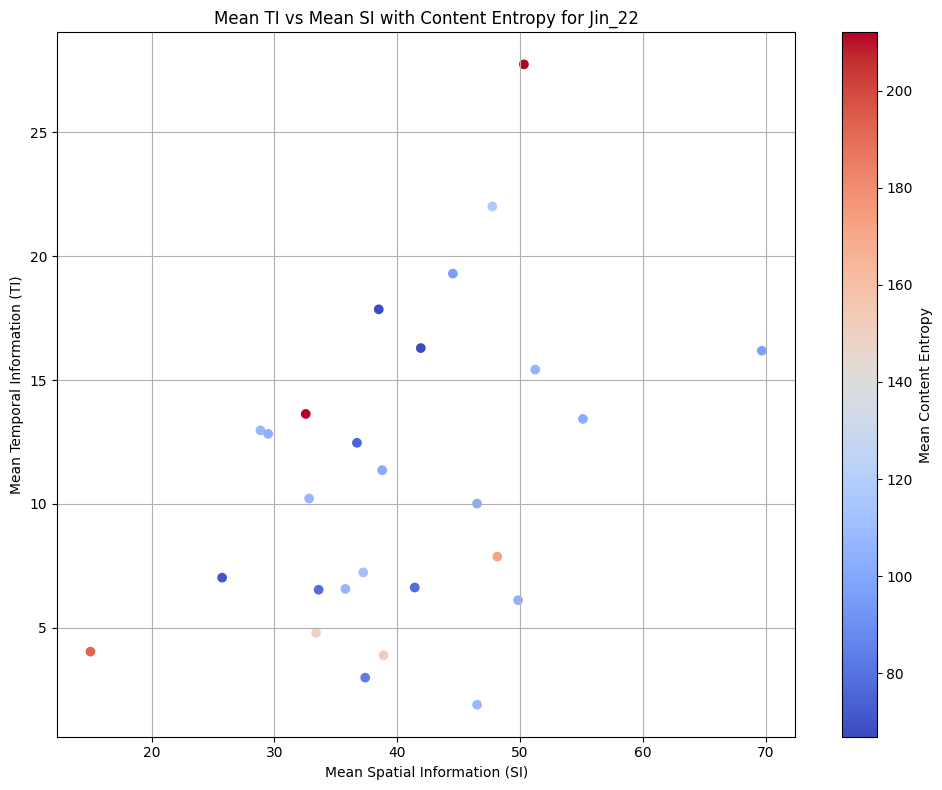

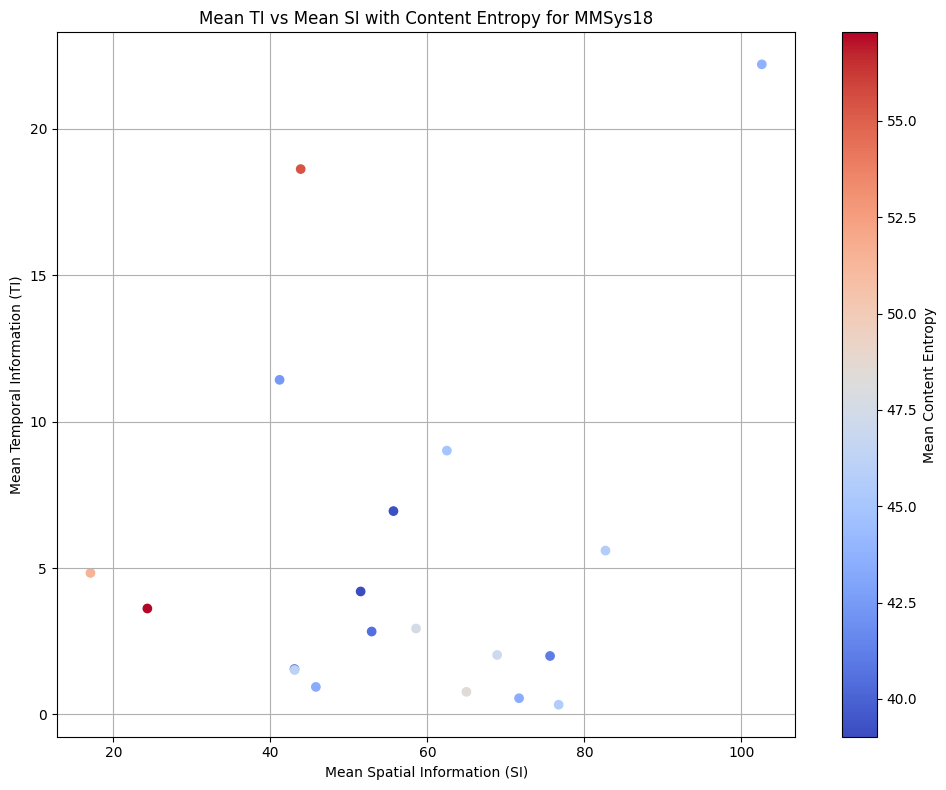

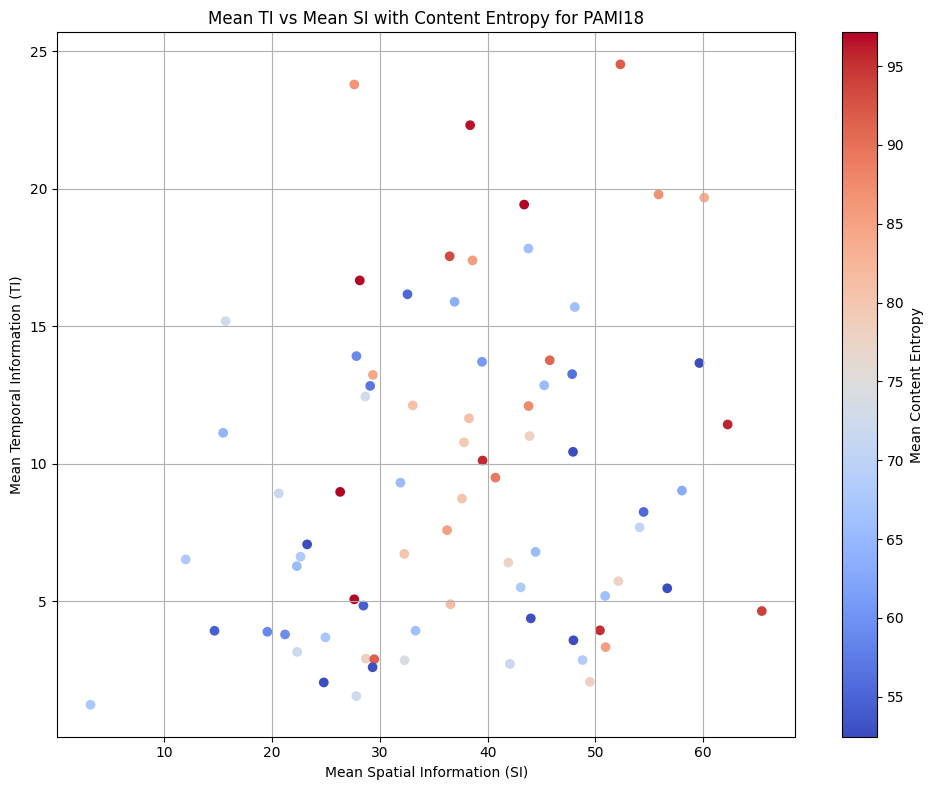

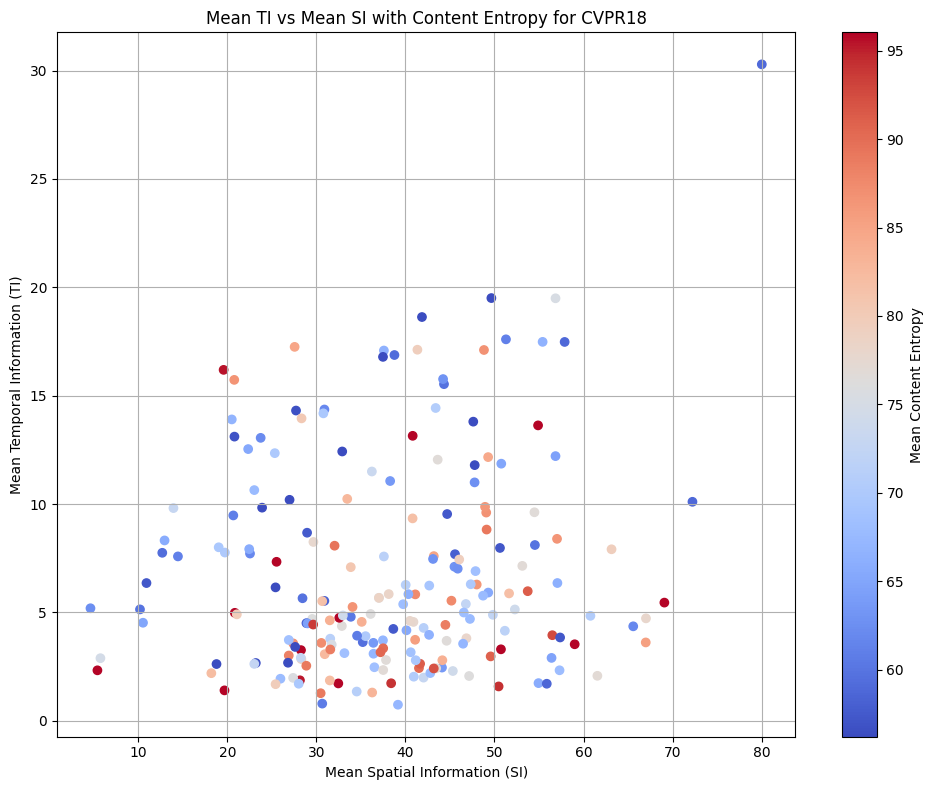

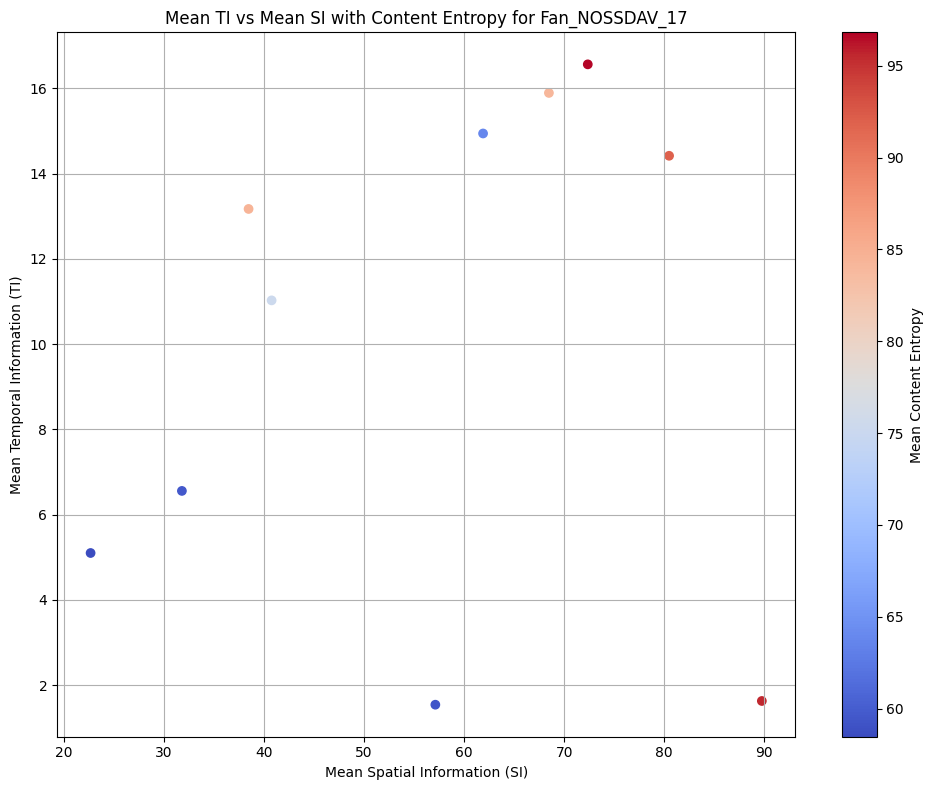

In [107]:
for dataset in datasets:
    plot_mean_entropy_vs_SITI(datasets_folder, dataset)

In [138]:
def fetch_entropies(datasets_folder,dataset):
    dataset_folder = os.path.join(datasets_folder, dataset)
    video_img_folder = os.path.join(dataset_folder, '5fps_Video_Images')
    data_path = os.path.join(dataset_folder, 'video_data')
    videos = os.listdir(video_img_folder)
    entropies={}
    aes={}
    IEs={}
    for video in videos:
        entropy_path = os.path.join(data_path, video, f'{video}_content_entropy.npy')
        ae_path=os.path.join(data_path,video, f'{video}_AEs.npy')
        IE_path=os.path.join(data_path, video, f'{video}_IEs.npy')
        entropy=np.load(entropy_path)
        ae=np.load(ae_path)
        ie=np.load(IE_path)
        entropies[video]=entropy
        aes[video]=ae
        IEs[video]=ie
    return entropies,aes,IEs

def plot_mean_AEs_vs_entropy(entropies, aes,dataset,color='blue'):
    mean_entropies = []
    mean_AEs = []
    
    for video in entropies:
        mean_entropies.append(np.mean(entropies[video]))
        mean_AEs.append(np.mean(aes[video]))
    
    plt.figure(figsize=(8, 6))
    plt.scatter(mean_AEs, mean_entropies, color=color, marker='o')
    #for i, video in enumerate(entropies):
    #    plt.annotate(video, (mean_AEs[i], mean_entropies[i]), fontsize=8)
    plt.title(f'{dataset} Mean Entropy vs Mean AE')
    plt.xlabel('Mean AEs')
    plt.ylabel('Mean Content Entropy')
    plt.grid(True)
    plots_folder = os.path.join('Plots', 'Entropies')
    os.makedirs(plots_folder, exist_ok=True)
    plot_path = os.path.join(plots_folder, f'{dataset}_contententropy_vs_AE.png')
    plt.savefig(plot_path)
    plt.show()

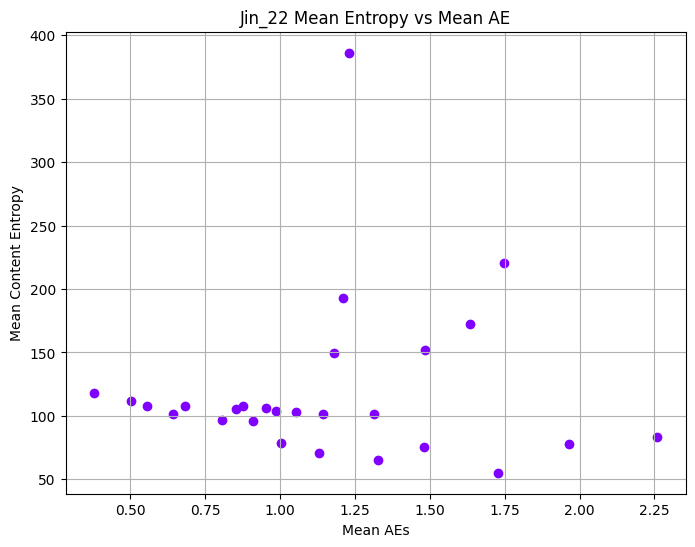

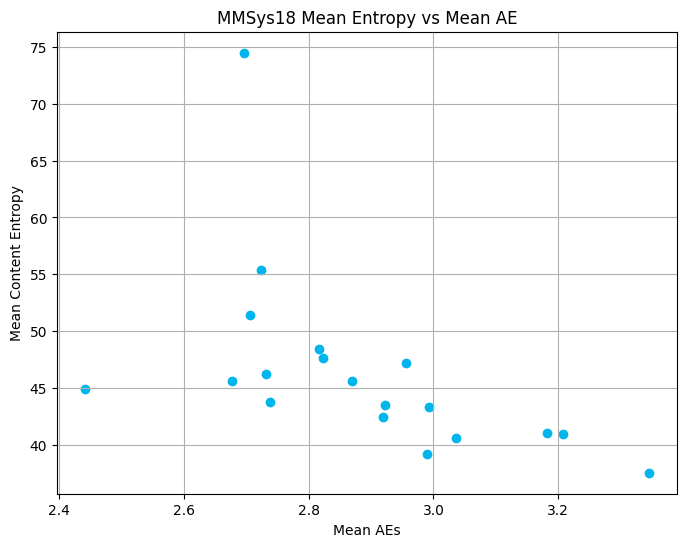

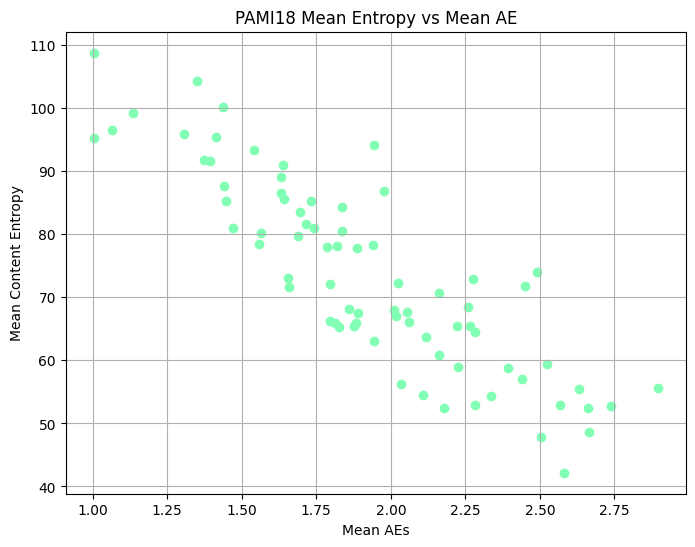

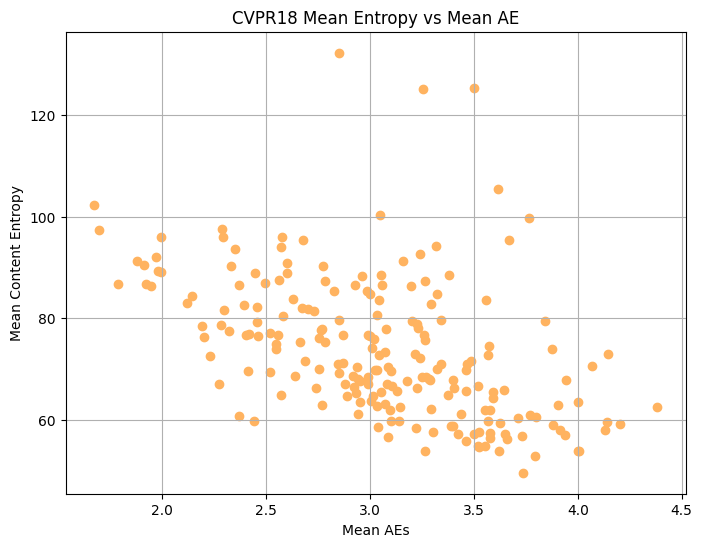

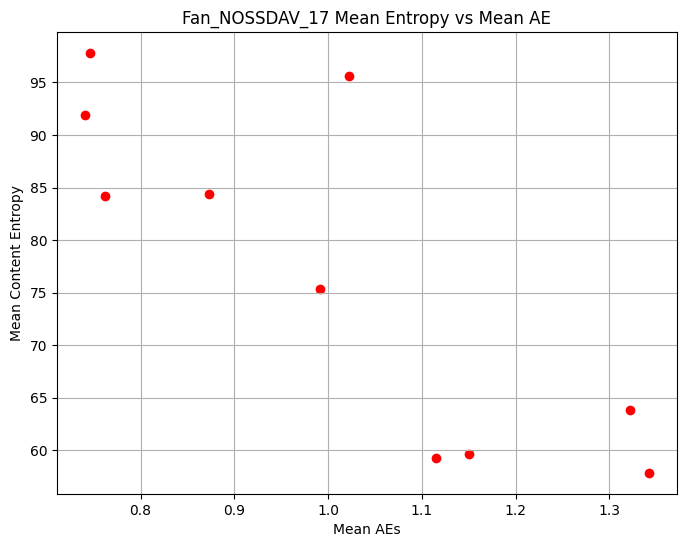

In [114]:
for idx,dataset in enumerate(datasets):
    c_entropies,aes,IEs=fetch_entropies(datasets_folder,dataset)
    plot_mean_AEs_vs_entropy(c_entropies, aes, dataset,color=dataset_colors[idx])

In [137]:
def min_max_norm(data):
    min_val=np.min(data)
    max_val=np.max(data)
    return (data-min_val)/(max_val-min_val)

In [115]:
def plot_IEs_vs_c_entropy(datasets_folder, dataset):
    entropies, aes, IEs = fetch_entropies(datasets_folder, dataset)
    
    # Pick a random video
    video = random.choice(list(entropies.keys()))
    
    # Extract content entropy and IEs for the selected video
    c_entropy = entropies[video]
    ie_values = IEs[video].reshape(-1,len(c_entropy))
    c_entropy_normalized = min_max_norm(c_entropy)

     # Calculate mean IEs across users
    mean_ie = np.mean(ie_values[:,1:], axis=0)  # Average across all users
    variance_ie = np.var(ie_values[:,1:], axis=0)   # variance across all users

    # Normalize mean IEs
    mean_ie_normalized = min_max_norm(mean_ie)
    variance_ie_normalized = min_max_norm(variance_ie)
    std_ie = np.std(ie_values[:,1:], axis=0)

    # Plotting
    fig, ax1 = plt.subplots(figsize=(10, 6))

    # Plot content entropy on the first y-axis
    ax1.plot(c_entropy[1:], label='Content Entropy', color='blue', marker='o')
    ax1.set_xlabel('Frame Index')
    ax1.set_ylabel('Content Entropy', color='blue')
    ax1.tick_params(axis='y', labelcolor='blue')

    # Create a second y-axis for the IEs
    ax2 = ax1.twinx()
    ax2.plot(mean_ie[1:], label='Mean IEs', color='orange', marker='x')
    ax2.fill_between(range(len(mean_ie)), mean_ie - std_ie, mean_ie + std_ie, color='orange', alpha=0.3, label='IEs Variance')
    ax2.set_ylabel('IEs', color='orange')
    ax2.tick_params(axis='y', labelcolor='orange')

    # Combine legends
    lines, labels = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax1.legend(lines + lines2, labels + labels2, loc='upper right')

    plt.title(f'Content Entropy vs Mean and Variance IEs for Video: {video}')
    plt.grid()
    plt.show()


In [166]:
def save_IEs_vs_c_entropy(datasets_folder, dataset):
    entropies, aes, IEs = fetch_entropies(datasets_folder, dataset)
    
    # Create directory for plots if it doesn't exist
    plot_dir = os.path.join('Plots','content_entropy_vs_IE', dataset)
    os.makedirs(plot_dir, exist_ok=True)
    print(f"Processing {dataset}")
    # Calculate mean content entropy for each video
    mean_entropies = {video: np.mean(entropies[video]) for video in entropies.keys()}
    
    # Sort videos based on mean content entropy
    sorted_videos = sorted(mean_entropies.keys(), key=lambda x: mean_entropies[x])
    
    # Iterate over sorted videos and save plots
    for rank, video in enumerate(sorted_videos, start=1):
        #print(f"procesing {video}")
        # Extract content entropy and IEs for the selected video
        c_entropy = entropies[video]
        c_entropy=c_entropy[:IEs[video].shape[1]]
        ie_values = IEs[video].reshape(-1, len(c_entropy))

        # Calculate mean and standard deviation of IEs across users
        mean_ie = np.mean(ie_values, axis=0)  # Average across all users
        std_ie = np.std(ie_values, axis=0)  # Standard deviation across all users
        # Plotting
        fig, ax1 = plt.subplots(figsize=(10, 6))
        
        # Plot content entropy on the first y-axis
        ax1.plot(c_entropy[1:], label='Content Entropy', color='blue', marker='o')
        ax1.set_xlabel('Frame Index')
        ax1.set_ylabel('Content Entropy', color='blue')
        ax1.tick_params(axis='y', labelcolor='blue')
        ax1.set_ylim(0,140)

        # Create a second y-axis for the IEs
        ax2 = ax1.twinx()
        ax2.plot(mean_ie[1:], label='Mean IEs', color='orange', marker='x')
        ax2.plot(std_ie[1:],label='IE variance', color='red',marker='|')
        ax2.fill_between(range(len(mean_ie[1:])), mean_ie[1:] - std_ie[1:], mean_ie[1:] + std_ie[1:], color='orange', alpha=0.3, label='IEs Variance')
        ax2.set_ylabel('IEs', color='orange')
        ax2.tick_params(axis='y', labelcolor='orange')
        ax2.set_ylim(0,6)
        # Combine legends
        lines, labels = ax1.get_legend_handles_labels()
        lines2, labels2 = ax2.get_legend_handles_labels()
        ax1.legend(lines + lines2, labels + labels2, loc='upper right')

        plt.title(f'Content Entropy vs Mean and Variance IEs for Video: {video}')
        plt.grid()
        # Save plot
        plot_path = os.path.join(plot_dir, f'Rank{rank}_{video}_contententropy_vs_IE.png')
        plt.savefig(plot_path)
        plt.close(fig)  # Close the figure to save memory

In [167]:
for dataset in datasets:
    save_IEs_vs_c_entropy(datasets_folder, dataset)

Processing Jin_22
Processing MMSys18
Processing PAMI18
Processing CVPR18
Processing Fan_NOSSDAV_17
